# 01. Node classification

![images/009.png](images/009.png)

![images/010.png](images/010.png)

# 02. Node Embeddings with TransE

![images/011.png](images/011.png)

![images/012.png](images/012.png)

![images/013.png](images/013.png)

![images/014.png](images/014.png)

![images/015.png](images/015.png)

- [x] Relational Classication
- [x] Belief Propagation
- [ ] Warmup: Why the Comparative Loss?
- [ ] The Purpose of the Margin
- [ ] Why are Entity Embeddings Normalized?
- [ ] Where TransE fails

In [1]:
import snap
import numpy as np
import wget
import os
import gzip
from graphviz import Graph
from graphviz import Source
import matplotlib.pyplot as plt

In [2]:
def gz_data_loader(data_url):
    file_to_load = wget.download(data_url)
    filename = os.path.splitext(os.path.basename(data_url))[0]
    os.replace(file_to_load, os.path.join('input', file_to_load))

    with gzip.open(os.path.join('input', file_to_load), 'rb') as f:
        f_in = f.read()
        with open(os.path.join('input', filename), 'wb') as f_out:
            f_out.write(f_in)
            print('\n{} loaded and unpacked'.format(os.path.basename(data_url)))

In [3]:
import hw2

## Relational Classication

In [4]:
G = snap.TUNGraph.New()
for n in range(1, 11):
    G.AddNode(n)
G.AddEdge(1, 2)
G.AddEdge(1, 3)
G.AddEdge(2, 3)
G.AddEdge(2, 4)
G.AddEdge(4, 7)
G.AddEdge(7, 8)
G.AddEdge(4, 8)
G.AddEdge(8, 5)
G.AddEdge(8, 9)
G.AddEdge(3, 6)
G.AddEdge(6, 5)
G.AddEdge(6, 9)
G.AddEdge(9, 5)
G.AddEdge(6, 10)
G.AddEdge(10, 9)

-1

In [5]:
snap.DrawGViz(G, snap.gvlNeato, "images/HW2RelationalClassication.png", "HW2RelationalClassication", True)

![images/HW2RelationalClassication.png](images/HW2RelationalClassication.png)

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [7]:
G1 = nx.Graph()
edges = [(1, 2), (1, 3), (2, 3), (2, 4), (4, 7), (7, 8), (4, 8), (8, 5), (8, 9), (3, 6), (3, 6), (6, 5), 
        (6, 9), (9, 5), (6, 10), (10, 9)]
G1.add_edges_from(edges)
for i in (3, 5):
    G1.nodes[i]['weight'] = 1
for i in (8, 10):
    G1.nodes[i]['weight'] = 0
for i in (1, 2, 4, 6, 7, 9):
    G1.nodes[i]['weight'] = 0.5

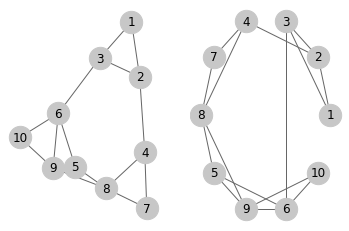

In [8]:
plt.subplot(121)
nx.draw(G1, node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)
plt.subplot(122)
nx.draw(G1, pos=nx.circular_layout(G1), node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)

In [9]:
for i, j in G1.nodes(data=True):
    print('{0}: {1}'.format(i, j['weight']))

1: 0.5
2: 0.5
3: 1
4: 0.5
7: 0.5
8: 0
5: 1
9: 0.5
6: 0.5
10: 0


In [10]:
def prob_pred(N, Graph):
    for n in list(range(N)):
        for i in list(range(10)):
            if Graph.nodes[i+1]['weight'] and Graph.nodes[i+1]['weight'] != 1:
                neighbors = list(nx.neighbors(Graph, i+1))
                n_p = 0
                e_weight = 1
                for j in neighbors:
                    n_p += Graph.nodes[j]['weight'] * e_weight
                p = n_p / len(neighbors)
                Graph.nodes[i+1]['weight'] = p
    return Graph

In [11]:
G_p = prob_pred(2, G1.copy())

In [12]:
for i, j in G_p.nodes(data=True):
    print('{0}: {1}'.format(i, j['weight']))

1: 0.875
2: 0.7638888888888888
3: 1
4: 0.32407407407407407
7: 0.16203703703703703
8: 0
5: 1
9: 0.400390625
6: 0.6015625
10: 0


In [13]:
[i[0] for i in G_p.nodes(data=True) if i[1]['weight'] > 0.5]

[1, 2, 3, 5, 6]

In [14]:
[i[0] for i in G_p.nodes(data=True) if i[1]['weight'] <= 0.5]

[4, 7, 8, 9, 10]

In [15]:
for i in (2, 4, 6):
    print('Probability of node {0} is {1}'.format(i, G_p.nodes[i]['weight']))

Probability of node 2 is 0.7638888888888888
Probability of node 4 is 0.32407407407407407
Probability of node 6 is 0.6015625


# Belief Propagation

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [17]:
G2 = nx.Graph()
edgesG2 = [('x1', 'y1'), ('x1', 'x2'), ('x2', 'y2'), ('x2', 'x3'), ('x2', 'x4'), ('x3', 'y3'), ('x4', 'y4')]
G2.add_edges_from(edgesG2)

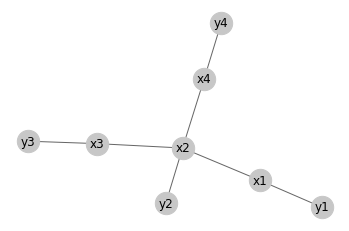

In [18]:
plt.subplot(111)
nx.draw(G2, node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)

$b_1(x_1) = \kappa\phi_1(x_1)m_{21}(x_1)$

где $m_{21}$ - это сообщение от ноды 2 к ноде 1 о том, что состояние ноды 2 думает о ноде 1.

$\kappa$ - коэффициент, обеспечивающий то, что вероятность сойдется в 1

$\phi_1(x_1)$ - вероятность того, что нода 1 находится в состоянии $x_1$

Распишем $m_{21}(x_1)$:

$$b_1(x_1) = \kappa\phi_1(x_1)\sum_{x_2}\psi_{12}(x_1, x_2)\phi_2(x_2)m_{32}(x_2)m_{42}(x_2)$$

где $\psi_{12}(x_1, x_2)$ - вероятность нахождения узла 1 в состоянии $x_1$, учитывая, что у него есть сосед 2 в состоянии $x_2$

распишем $m_{32}(x_2)m_{42}(x_2)$:

$$b_1(x_1) = \kappa\phi_1(x_1)\sum_{x_2}\psi_{12}(x_1, x_2)\phi_2(x_2)\sum_{x_3}\phi_3(x_3)\psi_{23}(x_2, x_3)\sum_{x_3}\phi_3(x_3)\psi_{23}(x_2, x_3)$$

В результате:

$$b_1(x_1) = \kappa\sum_{x_2, x_3, x_4}p(\{x\}) = p_1(x_1)$$

[Understanding_Belief_Propogation.pdf](http://people.csail.mit.edu/billf/publications/Understanding_Belief_Propogation.pdf)

#### Coding

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [20]:
G3 = nx.Graph()
edgesG3 = [('x1', 'x2'), ('x2', 'y2'), ('x2', 'x3'), ('x3', 'x4'), ('x3', 'x5'), ('x4', 'y4')]
G3.add_edges_from(edgesG3)

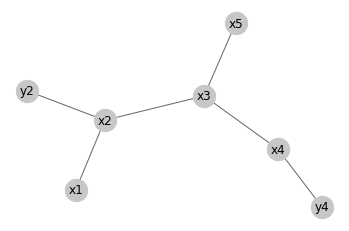

In [21]:
plt.subplot(111)
nx.draw(G3, node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)

In [22]:
G3.edges['x1', 'x2']['psi'] = G3.edges['x3', 'x4']['psi'] = np.array([[1, 0.9], [0.9, 1]])
G3.edges['x2', 'x3']['psi'] = G3.edges['x3', 'x5']['psi'] = np.array([[0.1, 1], [1, 0.1]])
G3.edges['x2', 'y2']['phi'] = G3.edges['x4', 'y4']['phi'] = np.array([[1, 0.1], [0.1, 1]])
G3.nodes['y2']['state'] = 0
G3.nodes['y4']['state'] = 1

In [23]:
G3.nodes(data=True)

NodeDataView({'x1': {}, 'x2': {}, 'y2': {'state': 0}, 'x3': {}, 'x4': {}, 'x5': {}, 'y4': {'state': 1}})

In [24]:
G3.edges(data=True)

EdgeDataView([('x1', 'x2', {'psi': array([[1. , 0.9],
       [0.9, 1. ]])}), ('x2', 'y2', {'phi': array([[1. , 0.1],
       [0.1, 1. ]])}), ('x2', 'x3', {'psi': array([[0.1, 1. ],
       [1. , 0.1]])}), ('x3', 'x4', {'psi': array([[1. , 0.9],
       [0.9, 1. ]])}), ('x3', 'x5', {'psi': array([[0.1, 1. ],
       [1. , 0.1]])}), ('x4', 'y4', {'phi': array([[1. , 0.1],
       [0.1, 1. ]])})])

$m_{43} = \phi_4(x_4, y_4)$

$m_{32} = m_{43}\psi_{35}(x_3, x_5)$

$m_{21} = m_{32}\phi_2(x_2, y_2)$

$m_{23} = \psi_{12}(x_1, x_2)\phi_2(x_2, y_2)$

$m_{34} = m_{23}\psi_{35}(x_3, x_5)$

$m_{35} = m_{23}m_{43}$

$b_1(x_1) = m_{21} = m_{32}\phi_2(x_2, y_2) = m_{43}\psi_{35}(x_3, x_5)\phi_2(x_2, y_2) = \phi_4(x_4, y_4)\psi_{35}(x_3, x_5)\phi_2(x_2, y_2)$

$b_2(x_2) = m_{32}\psi_{12}(x_1, x_2)\phi_2(x_2, y_2) = m_{43}\psi_{35}(x_3, x_5)\psi_{12}(x_1, x_2)\phi_2(x_2, y_2) = \phi_4(x_4, y_4)\psi_{35}(x_3, x_5)\psi_{12}(x_1, x_2)\phi_2(x_2, y_2)$

$b_3(x_3) = m_{23}m_{43}\psi_{35}(x_3, x_5) = \psi_{12}(x_1, x_2)\phi_2(x_2, y_2)\phi_4(x_4, y_4)\psi_{35}(x_3, x_5)$

$b_4(x_4) = m_{34}\phi_4(x_4, y_4) = m_{23}\psi_{35}(x_3, x_5)\phi_4(x_4, y_4) = \psi_{12}(x_1, x_2)\phi_2(x_2, y_2)\psi_{35}(x_3, x_5)\phi_4(x_4, y_4)$

$b_5(x_5) = m_{35} = m_{23}m_{43} = \psi_{12}(x_1, x_2)\phi_2(x_2, y_2)\phi_4(x_4, y_4)$

In [25]:
b1 = (G3.edges['x4', 'y4']['phi'] + G3.edges['x3', 'x5']['psi'] + 
      G3.edges['x2', 'y2']['phi'])
b1

array([[2.1, 1.2],
       [1.2, 2.1]])

In [26]:
b2 = (G3.edges['x4', 'y4']['phi'] + G3.edges['x3', 'x5']['psi'] + 
      G3.edges['x1', 'x2']['psi'] + G3.edges['x2', 'y2']['phi'])
b2

array([[3.1, 2.1],
       [2.1, 3.1]])

In [27]:
b3 = (G3.edges['x1', 'x2']['psi'] + G3.edges['x2', 'y2']['phi'] + 
      G3.edges['x4', 'y4']['phi'] + G3.edges['x3', 'x5']['psi'])
b3

array([[3.1, 2.1],
       [2.1, 3.1]])

In [28]:
b4 = (G3.edges['x1', 'x2']['psi'] + G3.edges['x2', 'y2']['phi'] + 
      G3.edges['x3', 'x5']['psi'] + G3.edges['x4', 'y4']['phi'])
b4

array([[3.1, 2.1],
       [2.1, 3.1]])

In [29]:
b5 = (G3.edges['x1', 'x2']['psi'] + G3.edges['x2', 'y2']['phi'] + 
      G3.edges['x4', 'y4']['phi'])
b5

array([[3. , 1.1],
       [1.1, 3. ]])

[статья с неплохим разъяснением как это устроено](http://jsbachvu.blogspot.com/2017/05/a-step-by-step-numerical-example-loopy-belief-propagation.html)

## Node Embeddings with TransE

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

Граф $G = (E, S, L)$

$E$ - ноды (entities)
$S$ - ребра
$L$ - возможные связи

$S$ содержит триплеты $(h, l, t)$, где:

- $h \in E$ нода источник (head)
- $l \in L$ связь
- $t \in E$ нода в конце связи (tail)

$e \in E$, принадлежит $\mathbb{R}^k$ - k-мерный вектор, собственно эмбединг. В TransE $l \in \mathbb{R}^k$

Если $(h, l, t) \in S$, то $\mathbf{h} + \mathbf{l} \approx \mathbf{t}$, в противном случае $\mathbf{h} + \mathbf{l} \neq \mathbf{t}$

$(h, l, t)$ - праильный триплет

$(h', l, t')$ - неправильный (corrupted), выбранный из $S'_{h, l, t}$, где $h$ или $t$ (но не оба) заменены на случайные, не входящие в $S$

В итоге задача TransE - минимизировать:

$\Lambda = \sum_{h, l, t) \in S} (\sum_{h', l, t') \in S'} [\gamma + d(\mathbf{h} + \mathbf{l}, \mathbf{t}) - d(\mathbf{h'} + \mathbf{l}, \mathbf{t'})]_+)$

In [4]:
x1 = np.array([[0, 1], [0, 1]])
x2 = np.array([[1, 0], [1, 0]])
x3 = np.array([[0, -1], [0, -1]])
x4 = np.array([[1, 2], [1, 2]])

In [27]:
G4 = nx.MultiGraph()
edgesG4 = [('x1', 'x2'), ('x2', 'x3'), ('x2', 'x4'), ('x3', 'x1')]
G4.add_edges_from(edgesG4)

[0, 0, 0, 0]

In [28]:
G4.nodes(data=True)

NodeDataView({'x1': {}, 'x2': {}, 'x3': {}, 'x4': {}})

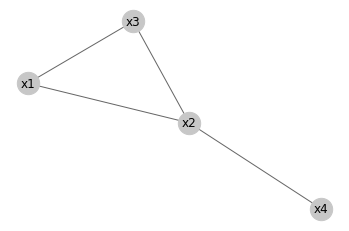

In [29]:
plt.subplot(111)
nx.draw(G4, node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)

In [30]:
l_12 = x2 - x1
l_12

array([[ 1, -1],
       [ 1, -1]])

In [31]:
l_23 = x3 - x2
l_23

array([[-1, -1],
       [-1, -1]])

In [32]:
l_24 = x4 - x2
l_24

array([[0, 2],
       [0, 2]])

In [33]:
l_41 = x1 - x3
l_41

array([[0, 2],
       [0, 2]])